In [1]:
import sys
sys.path = ["/home/wukailu/OmniNerf"] + sys.path
import os
os.environ['LOCAL_BACKEND']="1"
import matplotlib.pyplot as plt

In [2]:
from run_nerf import render_path
def render_imgs(rays_o, rays_d, model_path, args):
    from open_source.omni_nerf_new import load_nerf
    dev = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    render_kwargs = load_nerf(args, dev, ckpt_path=model_path)
    render_kwargs['near'] = 0
    render_kwargs['far'] = 20
    rgbs, _ = render_path([rays_o.reshape(-1,3).to(dev), rays_d.reshape(-1,3).to(dev)], [rays_o.size(1), rays_o.size(2)], render_kwargs)
    return rgbs

using local_backend
using  local_backend


In [3]:
import numpy as np
from PIL import Image
def get_rand_pos(model_path, total_samples = 10):
    d = np.array(Image.open('/data/Standford/area_3/pano/depth/' + model_path.split("/")[-1][:-len(".tar")] + "_depth.png"))
    d[d == 65535] = 0
    d = d / 512.0  # accurate dis
    samples = d[d.shape[0]//2]
    samples = np.clip(samples * 0.8, 0, 5)  # 太远的话，合成结果太差
    # sample from pdf
    rands = [np.random.choice(np.arange(0, len(samples)), p=samples/sum(samples)) for i in range(total_samples)]
    dir_np = getRay_d(d.shape[0], d.shape[1])
    rand_pos = dir_np[d.shape[0]//2, rands] * (np.random.rand(total_samples) * samples[rands])[:, None]
    return rand_pos

In [4]:
import torch
from load_st3d import getRay_d
from easydict import EasyDict

def render_pos(pos, model_path):
#     rays_d = torch.tensor(getRay_d(512, 1024))[None].float()
    rays_d = torch.tensor(getRay_d(256, 512))[None].float()
    rays_o = torch.tensor(pos).float().expand(rays_d.shape)
    args = EasyDict(
        dataset_type = "st3d",
        N_rand = 1400,
        N_samples = 64,
        N_importance = 128,
        use_viewdirs = False,
        raw_noise_std = 0,
        multires = 10,
        multires_views = 4,
        use_gradient = False,
        use_depth = True,
        use_dist = True,
        i_embed = 0,
        netdepth = 8,
        netdepth_fine = 8,
        netwidth = 256,
        netwidth_fine = 256,
        netchunk = 65536,
    )
    rgb = render_imgs(rays_o, rays_d, model_path, args)[0]
    return rgb

In [5]:
def to_cam_frame(c2w, pts):
    """
    pts: tensor in shape of [points, 3]
    """
    w2c = torch.tensor(np.linalg.inv(c2w))
    pts = torch.tensor(pts)
    ori_shape = pts.shape
    pts = pts.reshape((-1, 3)).T
    return (w2c @ torch.cat([pts, torch.ones_like(pts)[:1, :]], dim=0))[:3, :].T.reshape(ori_shape).numpy()

* 相机坐标系： 正+z,上+y，右+x
* OmniNerf 的坐标系 +x向前，+y向上, +z向右

In [6]:
def to_omniNerf_cam(pos):
    return np.array([pos[2], pos[1], pos[0]])

def to_st_cam(pos):
    return np.array([pos[2], pos[1], pos[0]])

In [7]:
import json

def to_world_frame(c2w, pts):
    """
    pts: tensor in shape of [points, 3]
    """
    ori_shape = pts.shape
    pts = pts.reshape((-1, 3)).T
    return (c2w @ torch.cat([pts, torch.ones_like(pts)[:1, :]], dim=0))[:3, :].T.reshape(ori_shape)

def get_abs_pos(model_path, pos):
    with open('/data/Standford/area_3/pano/pose/' + model_path.split("/")[-1][:-len(".tar")] + "_pose.json", "r") as fp:
        cfg = json.load(fp)
    c2w = np.linalg.inv(np.array(cfg['camera_rt_matrix'] + [[0.0, 0.0, 0.0, 1.0]]))
    return to_world_frame(torch.tensor(c2w), torch.tensor(to_st_cam(pos))).numpy()

In [ ]:
models = ["../results/" + relative for relative in os.listdir("../results")]
all_rgb = []
all_pos = []
for model_path in models:
    save_dir = "/home/wukailu/gen_correct/" + model_path.split("/")[-1][:-len(".tar")]
    os.makedirs(save_dir, exist_ok=True)
    rand_pos = get_rand_pos(model_path, total_samples = 10)
    for idx, pos in enumerate(rand_pos):
        print("position = ", pos)
        with torch.no_grad():
            rgb = render_pos(pos, model_path)
        abs_pos = get_abs_pos(model_path, pos)
        all_rgb.append(rgb)
        all_pos.append(abs_pos)
        Image.fromarray((rgb*255).astype(np.uint8)).save(save_dir+f"/{idx}.png")
        with open(save_dir+f"/{idx}.json", "w") as fp:
            json.dump({"position": list(abs_pos)},fp) 

position =  [ 1.25496301  0.         -0.88384467]
Found ckpts ../results/camera_87a1bc34ffb4408ba077119216ed763e_hallway_2_frame_equirectangular_domain.tar
Reloading from ../results/camera_87a1bc34ffb4408ba077119216ed763e_hallway_2_frame_equirectangular_domain.tar
render near, far =  0 20


  0%|                                                                                                                                                                                                             | 0/1 [00:00<?, ?it/s]

0 0.011452913284301758


In [ ]:
min_dis = 99999
pair = (0,0)
prs = []
for idi, i in enumerate(all_pos):
    for idj, j in enumerate(all_pos):
        if 2 > sum((i-j)**2) and idi < idj:
            pair = (idi, idj)
            min_dis = sum((i-j)**2)
            prs.append((idi, idj, min_dis))
prs

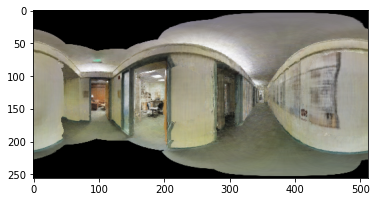

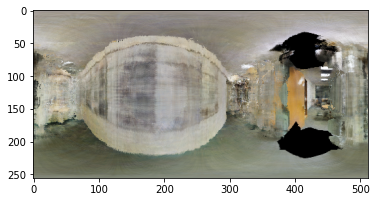

In [78]:
plt.imshow(all_rgb[6])
plt.show()
plt.imshow(all_rgb[17])
plt.show()

In [30]:
def show_depth_and_img(model_path):
    dep = Image.open('/data/Standford/area_3/pano/depth/' + model_path.split("/")[-1][:-len(".tar")] + "_depth.png")
    dep = np.array(dep)
    dep[dep == 65535] = 0
    dep = dep/512.0
    plt.imshow(dep)
    plt.show()
    img_rgb = Image.open('/data/Standford/area_3/pano/rgb/' + model_path.split("/")[-1][:-len(".tar")] + "_rgb.png")
    img_rgb = np.array(img_rgb)
    plt.imshow(img_rgb)
    plt.show()

In [9]:
def load_c2w(model_path):
    with open('/data/Standford/area_3/pano/pose/' + model_path.split("/")[-1][:-len(".tar")] + "_pose.json", "r") as fp:
        cfg = json.load(fp)
    return np.linalg.inv(np.array(cfg['camera_rt_matrix'] + [[0.0, 0.0, 0.0, 1.0]]))
c2w1 = load_c2w(models[1])
c2w15 = load_c2w(models[15])
print(c2w1[:3,3], c2w15[:3,3])

[12.97826439 -4.9462391   1.38585304] [11.70234182 -4.19177797  1.40416895]


In [27]:
print(to_cam_frame(c2w1, c2w1[:3,3]))
print(to_cam_frame(c2w1, c2w15[:3,3]))
# print(to_cam_frame(c2w15, c2w1[:3,3]))
print(to_omniNerf_cam(to_cam_frame(c2w1, c2w15[:3,3])))
# print(to_omniNerf_cam(to_cam_frame(c2w15, c2w1[:3,3])))

[ 0.00000000e+00 -9.71445147e-17  0.00000000e+00]
[-0.94333055 -0.01239031  1.14345942]
[ 1.14345942 -0.01239031 -0.94333055]


Found ckpts ../results/camera_ede7064adbbe490284373cf8c0cf8bae_lounge_2_frame_equirectangular_domain.tar
Reloading from ../results/camera_ede7064adbbe490284373cf8c0cf8bae_lounge_2_frame_equirectangular_domain.tar
render near, far =  0 20


  0%|                                                                                                                                                                                                             | 0/1 [00:00<?, ?it/s]

0 0.0027976036071777344


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:29<00:00, 29.98s/it]


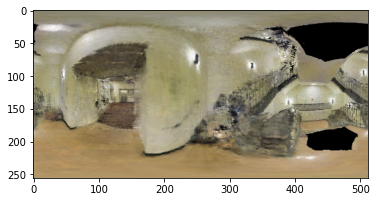

In [28]:
plt.imshow(render_pos(to_omniNerf_cam(to_cam_frame(c2w1, c2w15[:3,3])), models[1]))

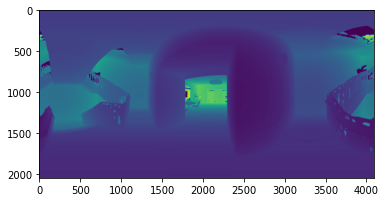

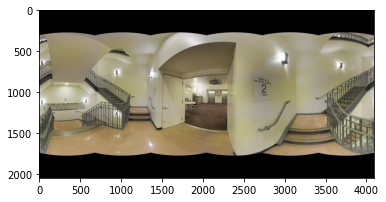

In [31]:
show_depth_and_img(models[15])

Found ckpts ../results/camera_1c029f7dc23548cab4ac62429f96eb76_lounge_2_frame_equirectangular_domain.tar
Reloading from ../results/camera_1c029f7dc23548cab4ac62429f96eb76_lounge_2_frame_equirectangular_domain.tar
render near, far =  0 20


  0%|                                                                                                                                                                                                             | 0/1 [00:00<?, ?it/s]

0 0.00299072265625


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:26<00:00, 26.54s/it]


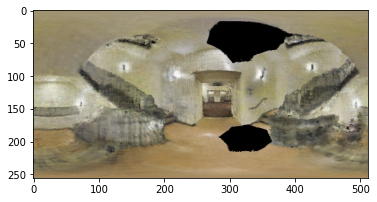

In [29]:
plt.imshow(render_pos(to_omniNerf_cam(to_cam_frame(c2w15, c2w1[:3,3])), models[15]))

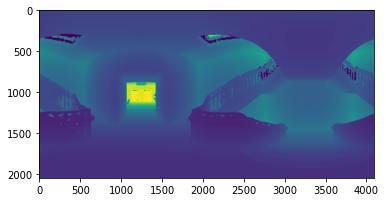

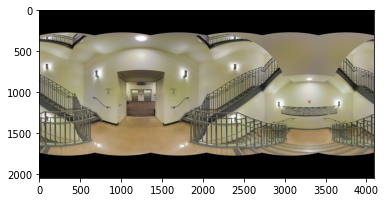

In [32]:
show_depth_and_img(models[1])

[-1.47875527  0.00185135 -0.1039467 ]
Found ckpts ../results/camera_ede7064adbbe490284373cf8c0cf8bae_lounge_2_frame_equirectangular_domain.tar
Reloading from ../results/camera_ede7064adbbe490284373cf8c0cf8bae_lounge_2_frame_equirectangular_domain.tar
render near, far =  0 20


  0%|                                                                                                                                                                                                             | 0/1 [00:00<?, ?it/s]

0 0.0032465457916259766


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:11<00:00, 11.34s/it]


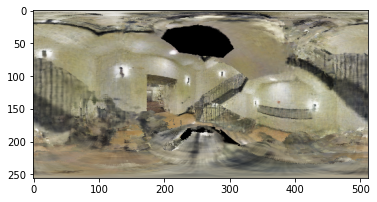

In [66]:
p1 = c2w1[:3,3]
query1 = to_omniNerf_cam(to_cam_frame(c2w15, p1))
print(query1)
plt.imshow(render_pos(query1, models[1]))

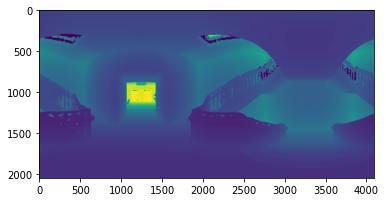

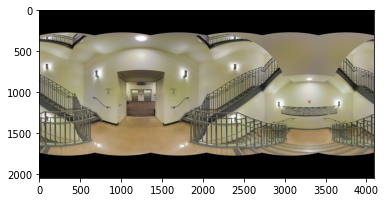

In [65]:
show_depth_and_img(models[1])

[ 0.14151248  0.01239031 -1.47558333]
Found ckpts ../results/camera_ede7064adbbe490284373cf8c0cf8bae_lounge_2_frame_equirectangular_domain.tar
Reloading from ../results/camera_ede7064adbbe490284373cf8c0cf8bae_lounge_2_frame_equirectangular_domain.tar
render near, far =  0 20


  0%|                                                                                                                                                                                                             | 0/1 [00:00<?, ?it/s]

0 0.0034618377685546875


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:11<00:00, 11.38s/it]


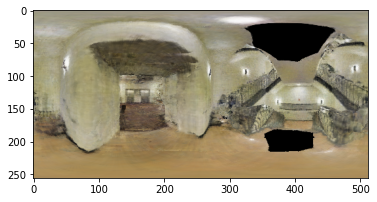

In [67]:
p2 = c2w15[:3,3]
query15 = to_omniNerf_cam(to_cam_frame(c2w1, p2))
print(query15)
plt.imshow(render_pos(query15, models[1]))

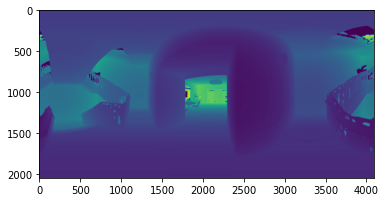

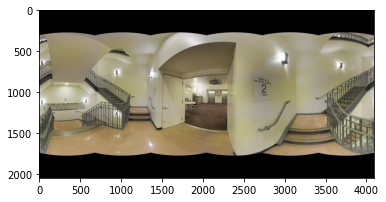

In [64]:
show_depth_and_img(models[15])